In [28]:
# 1.1 Import tensorflow and other libraries.
# http://efavdb.com/battleship/#mjx-eqn-rewards
import tensorflow as tf
import numpy as np
%matplotlib inline
import pylab

In [58]:
# 1.2 Define the nn variable network.
# Input is array of BOARD_SIZE values.
# ---------------------------------------
#  -1 value -> Not yet checked
#   0 value -> Checked, no ship
#   1 value -> Checked, is ship location.
# ---------------------------------------
BOARD_SIZE = 10
SHIP_SIZE = 3

hidden_units = BOARD_SIZE
output_units = BOARD_SIZE

input_positions = tf.placeholder(tf.float32, shape=(1, BOARD_SIZE))
print(input_positions)
labels = tf.placeholder(tf.int64)
print(labels)
learning_rate = tf.placeholder(tf.float32, shape=[])
print(learning_rate)
# Generate hidden layer
W1 = tf.Variable(tf.truncated_normal([BOARD_SIZE, hidden_units], stddev=0.1 / np.sqrt(float(BOARD_SIZE))))
print(W1)
b1 = tf.Variable(tf.zeros([1, hidden_units]))
print(b1)
h1 = tf.tanh(tf.matmul(input_positions, W1) + b1)
print(h1)
# Second layer -- linear classifier for action logits
W2 = tf.Variable(tf.truncated_normal([hidden_units, output_units], stddev=0.1 / np.sqrt(float(hidden_units))))
b2 = tf.Variable(tf.zeros([1, output_units]))
logits = tf.matmul(h1, W2) + b2 
print(logits)
probabilities = tf.nn.softmax(logits)
print(probabilities)


Tensor("Placeholder_63:0", shape=(1, 10), dtype=float32)
Tensor("Placeholder_64:0", dtype=int64)
Tensor("Placeholder_65:0", shape=(), dtype=float32)
Tensor("Variable_84/read:0", shape=(10, 10), dtype=float32)
Tensor("Variable_85/read:0", shape=(1, 10), dtype=float32)
Tensor("Tanh_21:0", shape=(1, 10), dtype=float32)
Tensor("add_44:0", shape=(1, 10), dtype=float32)
Tensor("Softmax_21:0", shape=(1, 10), dtype=float32)


In [52]:
# 1.3 Define the operations we will use
init = tf.global_variables_initializer()
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels, name='xentropy')
print(cross_entropy)
train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
print(train_step)
# Start TF session
sess = tf.Session()
sess.run(init)

Tensor("xentropy_9/xentropy:0", shape=(1,), dtype=float32)
name: "GradientDescent_9"
op: "NoOp"
input: "^GradientDescent_9/update_Variable_60/ApplyGradientDescent"
input: "^GradientDescent_9/update_Variable_61/ApplyGradientDescent"
input: "^GradientDescent_9/update_Variable_62/ApplyGradientDescent"
input: "^GradientDescent_9/update_Variable_63/ApplyGradientDescent"



In [31]:
# 1.4 Game play definition.
TRAINING = True
def play_game(training=TRAINING):
    """ Play game of battleship using network."""
    # Select random location for ship
    ship_left = np.random.randint(BOARD_SIZE - SHIP_SIZE + 1)
    ship_positions = set(range(ship_left, ship_left + SHIP_SIZE))
    # Initialize logs for game
    board_position_log = []
    action_log = []
    hit_log = []
    # Play through game
    current_board = [[-1 for i in range(BOARD_SIZE)]]
    while (sum(hit_log) < SHIP_SIZE) and (len(action_log) < BOARD_SIZE):
        board_position_log.append([[i for i in current_board[0]]])
        probs = sess.run([probabilities], feed_dict={input_positions:current_board})[0][0]
        probs = [p * (index not in action_log) for index, p in enumerate(probs)]
        probs = [p / sum(probs) for p in probs]
        if training == True:
            bomb_index = np.random.choice(BOARD_SIZE, p=probs)            
        else:
            bomb_index = np.argmax(probs)
        # update board, logs
        hit_log.append(1 * (bomb_index in ship_positions))
        current_board[0][bomb_index] = 1 * (bomb_index in ship_positions)
        action_log.append(bomb_index)
    return board_position_log, action_log, hit_log
# Example:
play_game()

([[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],
  [[-1, -1, -1, -1, -1, -1, -1, -1, 0, -1]],
  [[-1, -1, -1, -1, -1, -1, 1, -1, 0, -1]],
  [[-1, -1, 0, -1, -1, -1, 1, -1, 0, -1]],
  [[0, -1, 0, -1, -1, -1, 1, -1, 0, -1]],
  [[0, 0, 0, -1, -1, -1, 1, -1, 0, -1]],
  [[0, 0, 0, -1, 1, -1, 1, -1, 0, -1]],
  [[0, 0, 0, -1, 1, -1, 1, -1, 0, 0]],
  [[0, 0, 0, -1, 1, -1, 1, 0, 0, 0]],
  [[0, 0, 0, 0, 1, -1, 1, 0, 0, 0]]],
 [8, 6, 2, 0, 1, 4, 9, 7, 3, 5],
 [0, 1, 0, 0, 0, 1, 0, 0, 0, 1])

In [32]:
# 1.5 Reward function definition
def rewards_calculator(hit_log, gamma=0.5):
    """ Discounted sum of future hits over trajectory"""            
    hit_log_weighted = [(item - float(SHIP_SIZE - sum(hit_log[:index])) / float(BOARD_SIZE - index)) * (gamma ** index) for index, item in enumerate(hit_log)]
    return [((gamma) ** (-i)) * sum(hit_log_weighted[i:]) for i in range(len(hit_log))]

# Example
rewards_calculator([0,0,1,1,1])

[-0.16904761904761903,
 0.2619047619047619,
 1.1904761904761905,
 1.130952380952381,
 0.8333333333333334]

In [33]:
# 1.6 Training loop: Play and learn
game_lengths = []
TRAINING = True   # Boolean specifies training mode
ALPHA = 0.06      # step size

for game in range(10000):
    board_position_log, action_log, hit_log = play_game(training=TRAINING)
    game_lengths.append(len(action_log))
    rewards_log = rewards_calculator(hit_log)
    for reward, current_board, action in zip(rewards_log, board_position_log, action_log):
        # Take step along gradient
        if TRAINING:
            sess.run([train_step], 
                feed_dict={input_positions:current_board, labels:[action], learning_rate:ALPHA * reward})

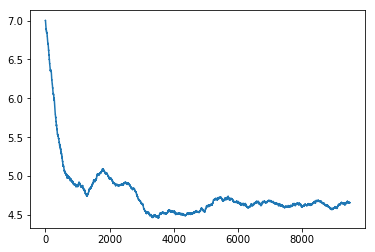

In [34]:
# 1.7 Plot running average game lengths
window_size = 500
running_average_length = [np.mean(game_lengths[i:i+window_size]) for i in range(len(game_lengths)- window_size)]
pylab.plot(running_average_length)

In [35]:
# 1.8 Example showing how to print current coefficient values
sess.run([W1], feed_dict={input_positions:board_position_log[0]})

[array([[  7.25901186e-01,   1.04886639e+00,   6.20839112e-02,
          -3.41061354e-02,   4.55370486e-01,   2.02341691e-01,
          -2.12955847e-01,   3.58229399e-01,   7.24420965e-01,
           3.38534296e-01],
        [ -1.57648444e+00,  -1.72019684e+00,  -1.80868149e+00,
          -7.12780356e-02,   1.11409567e-01,   1.63963601e-01,
           1.47185652e-02,   1.30413938e+00,  -2.37215042e+00,
           1.21751346e-01],
        [  1.37824535e+00,  -1.32748854e+00,  -1.55953240e+00,
           1.73858631e+00,  -3.07726669e+00,  -3.41630965e-01,
          -1.37973142e+00,   2.52039552e+00,   2.36320090e+00,
          -2.60692453e+00],
        [ -2.57445884e+00,   2.02244043e+00,   2.29665589e+00,
           1.36782777e+00,  -2.47151569e-01,  -2.57568288e+00,
          -1.09048522e+00,  -1.92701316e+00,  -2.55728292e+00,
          -4.62185621e-01],
        [  2.34399986e+00,  -9.83024359e-01,   2.24991977e-01,
          -1.41239774e+00,   2.62054294e-01,   4.87807579e-02,
      